## SVR for Fly ash and Slag

R² Score (Interpolation): -0.1320
MAE (Interpolation): 11.8859
MSE (Interpolation): 221.8951
RMSE (Interpolation): 14.8961
R² Score (Extrapolation): -12.6473
MAE (Extrapolation): 25.0452
MSE (Extrapolation): 676.9272
RMSE (Extrapolation): 26.0178


/Users/gzia/Documents/GitHub/Testing the limit of LLM/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['OPC - content in mix -  (kg/m3)' 'SF - content in mix -  (kg/m3)'
 'MK - content in mix -  (kg/m3)' 'Other SCM - content in mix -  (kg/m3)'
 'Initial Curing Process - duration - (day)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/gzia/Documents/GitHub/Testing the limit of LLM/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['OPC - content in mix -  (kg/m3)' 'SF - content in mix -  (kg/m3)'
 'MK - content in mix -  (kg/m3)' 'Other SCM - content in mix -  (kg/m3)'
 'Initial Curing Process - duration - (day)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/gzia/Documents/GitHub/Testing the limit of LLM/.venv/lib/python3.12/s

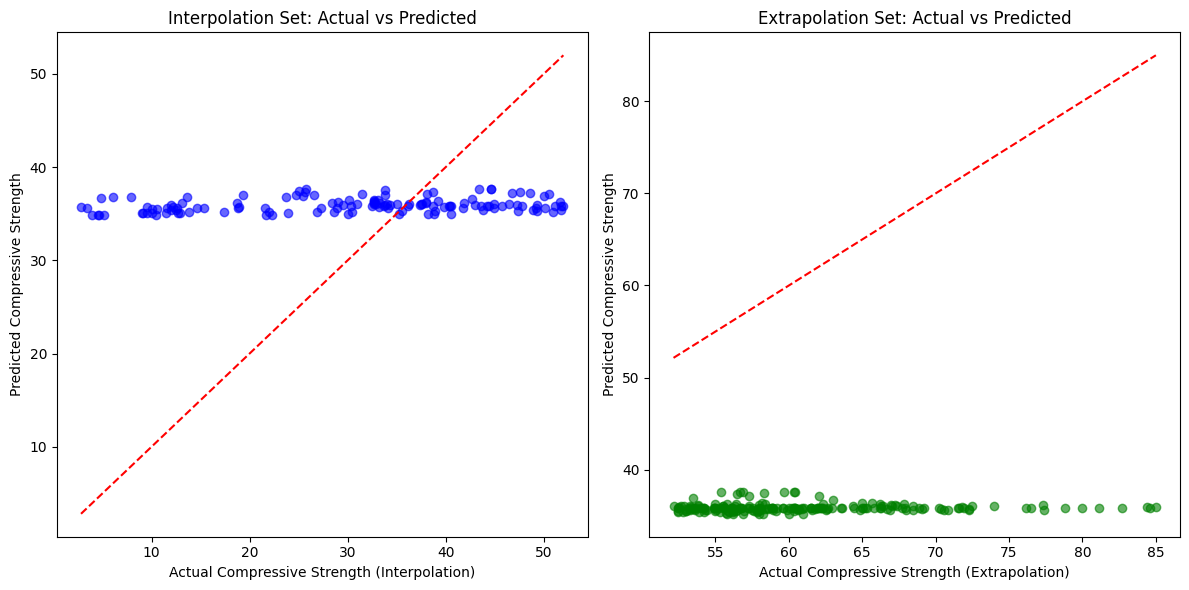

In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Load the previously filtered datasets
interp_train_path = '../excel_files/cubic_to_cylinder_intra_extrapolation/filter_based_on_binder/interpolation_train/fly_ash_and_slug_interpolation_train.xlsx'
interp_test_path = '../excel_files/cubic_to_cylinder_intra_extrapolation/filter_based_on_binder/interpolation_test/fly_ash_and_slug_interpolation_test.xlsx'
extrap_test_path = '../excel_files/cubic_to_cylinder_intra_extrapolation/filter_based_on_binder/extrapolation_test/fly_ash_and_slug_extrapolation_test.xlsx'

df_interp_train = pd.read_excel(interp_train_path)
df_interp_test = pd.read_excel(interp_test_path)
df_extrap_test = pd.read_excel(extrap_test_path)

# Select 10 initial samples randomly from interpolation training set
initial_samples = df_interp_train.sample(n=10, random_state=1)
remaining_interp_train = df_interp_train.drop(initial_samples.index)

# Prepare features and target
features = [
    "SiO2 %",
    "Al2O3 %",
    "Fe2O3 %",
    "CaO %",
    "OPC - content in mix -  (kg/m3)",
    "FA - content in mix -  (kg/m3)",
    "GGBFS - content in mix -  (kg/m3)",
    "SF - content in mix -  (kg/m3)",
    "MK - content in mix -  (kg/m3)",
    "Other SCM - content in mix -  (kg/m3)",
    "Total aggregates - content - (kg/m3)",
    "Water - content from all sources in mix - (kg/m3)",
    "SiO2 - liquid percentage in Na2SiO3 solution - %",
    "SiO2 -Dry content from Na2SiO3 solution in mix - (kg/m3)",
    "NaOH solution - content in mix - (kg/m3)",
    "NaOH solution - concentration - molar",
    "Superplasticizer - content - (kg/m3)",
    "Extra water - content in mix - (kg/m3)",
    "Initial Curing Process - duration - (day)",
    "Initial Curing Process - Temperature - (ºC)",
    "Test age",
]
target = "Compressive test"

# Define features and target for initial sample and test datasets
X_train = initial_samples[features]
y_train = initial_samples[target]
X_interp_test = df_interp_test[features]
y_interp_test = df_interp_test[target]
X_extrap_test = df_extrap_test[features]
y_extrap_test = df_extrap_test[target]

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_interp_test_imputed = imputer.transform(X_interp_test)
X_extrap_test_imputed = imputer.transform(X_extrap_test)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_interp_test_scaled = scaler.transform(X_interp_test_imputed)
X_extrap_test_scaled = scaler.transform(X_extrap_test_imputed)

# Initialize and train the SVR model
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)

# Predict on both interpolation and extrapolation test sets
y_interp_pred = svr_model.predict(X_interp_test_scaled)
y_extrap_pred = svr_model.predict(X_extrap_test_scaled)

# Calculate evaluation metrics
metrics = {
    "R² Score (Interpolation)": r2_score(y_interp_test, y_interp_pred),
    "MAE (Interpolation)": mean_absolute_error(y_interp_test, y_interp_pred),
    "MSE (Interpolation)": mean_squared_error(y_interp_test, y_interp_pred),
    "RMSE (Interpolation)": np.sqrt(mean_squared_error(y_interp_test, y_interp_pred)),
    "R² Score (Extrapolation)": r2_score(y_extrap_test, y_extrap_pred),
    "MAE (Extrapolation)": mean_absolute_error(y_extrap_test, y_extrap_pred),
    "MSE (Extrapolation)": mean_squared_error(y_extrap_test, y_extrap_pred),
    "RMSE (Extrapolation)": np.sqrt(mean_squared_error(y_extrap_test, y_extrap_pred)),
}

# Print the evaluation metrics
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot the predicted vs actual values for both interpolation and extrapolation sets
plt.figure(figsize=(12, 6))

# Interpolation plot
plt.subplot(1, 2, 1)
plt.scatter(y_interp_test, y_interp_pred, color='blue', alpha=0.6)
plt.plot([y_interp_test.min(), y_interp_test.max()], [y_interp_test.min(), y_interp_test.max()], 'r--')
plt.xlabel("Actual Compressive Strength (Interpolation)")
plt.ylabel("Predicted Compressive Strength")
plt.title("Interpolation Set: Actual vs Predicted")

# Extrapolation plot
plt.subplot(1, 2, 2)
plt.scatter(y_extrap_test, y_extrap_pred, color='green', alpha=0.6)
plt.plot([y_extrap_test.min(), y_extrap_test.max()], [y_extrap_test.min(), y_extrap_test.max()], 'r--')
plt.xlabel("Actual Compressive Strength (Extrapolation)")
plt.ylabel("Predicted Compressive Strength")
plt.title("Extrapolation Set: Actual vs Predicted")

plt.tight_layout()
plt.show()


## SVR for only Fly ash

R² Score (Interpolation): -0.0206
MAE (Interpolation): 10.2290
MSE (Interpolation): 148.8446
RMSE (Interpolation): 12.2002
R² Score (Extrapolation): -11.5191
MAE (Extrapolation): 30.5260
MSE (Extrapolation): 1011.0507
RMSE (Extrapolation): 31.7970


/Users/gzia/Documents/GitHub/Testing the limit of LLM/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['OPC - content in mix -  (kg/m3)' 'GGBFS - content in mix -  (kg/m3)'
 'SF - content in mix -  (kg/m3)' 'MK - content in mix -  (kg/m3)'
 'Other SCM - content in mix -  (kg/m3)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/gzia/Documents/GitHub/Testing the limit of LLM/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['OPC - content in mix -  (kg/m3)' 'GGBFS - content in mix -  (kg/m3)'
 'SF - content in mix -  (kg/m3)' 'MK - content in mix -  (kg/m3)'
 'Other SCM - content in mix -  (kg/m3)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/gzia/Documents/GitHub/Testing the limit of LLM/.venv/lib/python3.12/site-packages/skl

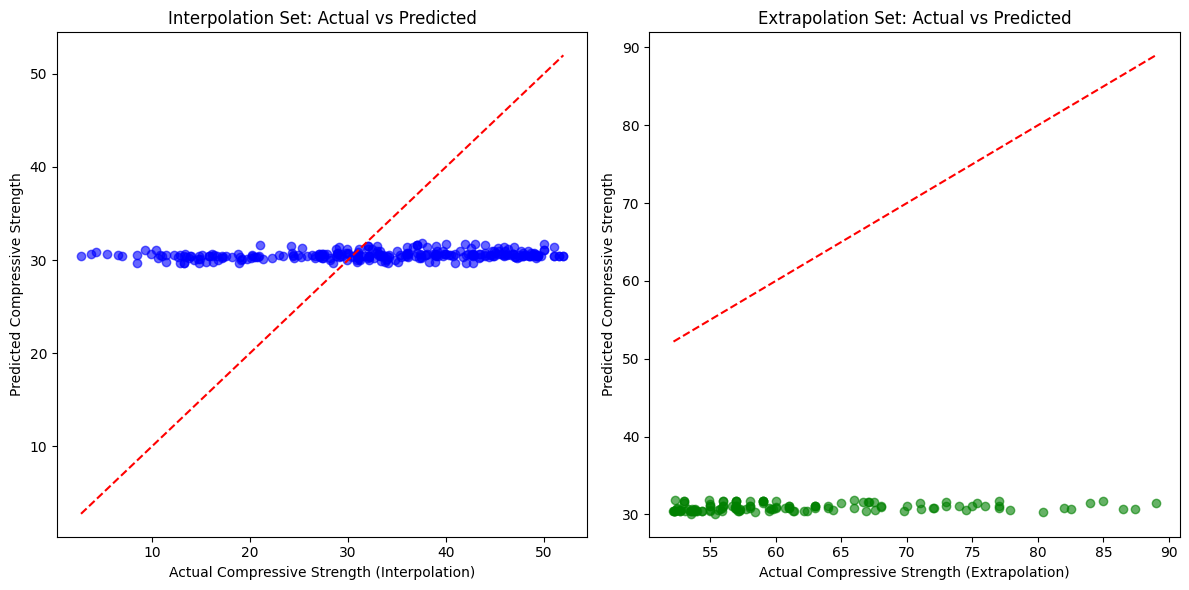

In [3]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Load the previously filtered datasets
interp_train_path = '../excel_files/cubic_to_cylinder_intra_extrapolation/filter_based_on_binder/interpolation_train/only_fly_ash_interpolation_train.xlsx'
interp_test_path = '../excel_files/cubic_to_cylinder_intra_extrapolation/filter_based_on_binder/interpolation_test/only_fly_ash_interpolation_test.xlsx'
extrap_test_path = '../excel_files/cubic_to_cylinder_intra_extrapolation/filter_based_on_binder/extrapolation_test/only_fly_ash_extrapolation_test.xlsx'

df_interp_train = pd.read_excel(interp_train_path)
df_interp_test = pd.read_excel(interp_test_path)
df_extrap_test = pd.read_excel(extrap_test_path)

# Select 10 initial samples randomly from interpolation training set
initial_samples = df_interp_train.sample(n=10, random_state=1)
remaining_interp_train = df_interp_train.drop(initial_samples.index)

# Prepare features and target
features = [
    "SiO2 %",
    "Al2O3 %",
    "Fe2O3 %",
    "CaO %",
    "OPC - content in mix -  (kg/m3)",
    "FA - content in mix -  (kg/m3)",
    "GGBFS - content in mix -  (kg/m3)",
    "SF - content in mix -  (kg/m3)",
    "MK - content in mix -  (kg/m3)",
    "Other SCM - content in mix -  (kg/m3)",
    "Total aggregates - content - (kg/m3)",
    "Water - content from all sources in mix - (kg/m3)",
    "SiO2 - liquid percentage in Na2SiO3 solution - %",
    "SiO2 -Dry content from Na2SiO3 solution in mix - (kg/m3)",
    "NaOH solution - content in mix - (kg/m3)",
    "NaOH solution - concentration - molar",
    "Superplasticizer - content - (kg/m3)",
    "Extra water - content in mix - (kg/m3)",
    "Initial Curing Process - duration - (day)",
    "Initial Curing Process - Temperature - (ºC)",
    "Test age",
]
target = "Compressive test"

# Define features and target for initial sample and test datasets
X_train = initial_samples[features]
y_train = initial_samples[target]
X_interp_test = df_interp_test[features]
y_interp_test = df_interp_test[target]
X_extrap_test = df_extrap_test[features]
y_extrap_test = df_extrap_test[target]

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_interp_test_imputed = imputer.transform(X_interp_test)
X_extrap_test_imputed = imputer.transform(X_extrap_test)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_interp_test_scaled = scaler.transform(X_interp_test_imputed)
X_extrap_test_scaled = scaler.transform(X_extrap_test_imputed)

# Initialize and train the SVR model
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)

# Predict on both interpolation and extrapolation test sets
y_interp_pred = svr_model.predict(X_interp_test_scaled)
y_extrap_pred = svr_model.predict(X_extrap_test_scaled)

# Calculate evaluation metrics
metrics = {
    "R² Score (Interpolation)": r2_score(y_interp_test, y_interp_pred),
    "MAE (Interpolation)": mean_absolute_error(y_interp_test, y_interp_pred),
    "MSE (Interpolation)": mean_squared_error(y_interp_test, y_interp_pred),
    "RMSE (Interpolation)": np.sqrt(mean_squared_error(y_interp_test, y_interp_pred)),
    "R² Score (Extrapolation)": r2_score(y_extrap_test, y_extrap_pred),
    "MAE (Extrapolation)": mean_absolute_error(y_extrap_test, y_extrap_pred),
    "MSE (Extrapolation)": mean_squared_error(y_extrap_test, y_extrap_pred),
    "RMSE (Extrapolation)": np.sqrt(mean_squared_error(y_extrap_test, y_extrap_pred)),
}

# Print the evaluation metrics
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot the predicted vs actual values for both interpolation and extrapolation sets
plt.figure(figsize=(12, 6))

# Interpolation plot
plt.subplot(1, 2, 1)
plt.scatter(y_interp_test, y_interp_pred, color='blue', alpha=0.6)
plt.plot([y_interp_test.min(), y_interp_test.max()], [y_interp_test.min(), y_interp_test.max()], 'r--')
plt.xlabel("Actual Compressive Strength (Interpolation)")
plt.ylabel("Predicted Compressive Strength")
plt.title("Interpolation Set: Actual vs Predicted")

# Extrapolation plot
plt.subplot(1, 2, 2)
plt.scatter(y_extrap_test, y_extrap_pred, color='green', alpha=0.6)
plt.plot([y_extrap_test.min(), y_extrap_test.max()], [y_extrap_test.min(), y_extrap_test.max()], 'r--')
plt.xlabel("Actual Compressive Strength (Extrapolation)")
plt.ylabel("Predicted Compressive Strength")
plt.title("Extrapolation Set: Actual vs Predicted")

plt.tight_layout()
plt.show()


## SVR for only Slag

R² Score (Interpolation): 0.0753
MAE (Interpolation): 7.1921
MSE (Interpolation): 70.0361
RMSE (Interpolation): 8.3688
R² Score (Extrapolation): -11.8501
MAE (Extrapolation): 26.8032
MSE (Extrapolation): 782.7171
RMSE (Extrapolation): 27.9771


/Users/gzia/Documents/GitHub/Testing the limit of LLM/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['OPC - content in mix -  (kg/m3)' 'FA - content in mix -  (kg/m3)'
 'SF - content in mix -  (kg/m3)' 'MK - content in mix -  (kg/m3)'
 'Other SCM - content in mix -  (kg/m3)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/gzia/Documents/GitHub/Testing the limit of LLM/.venv/lib/python3.12/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: ['OPC - content in mix -  (kg/m3)' 'FA - content in mix -  (kg/m3)'
 'SF - content in mix -  (kg/m3)' 'MK - content in mix -  (kg/m3)'
 'Other SCM - content in mix -  (kg/m3)']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/Users/gzia/Documents/GitHub/Testing the limit of LLM/.venv/lib/python3.12/site-packages/sklearn/i

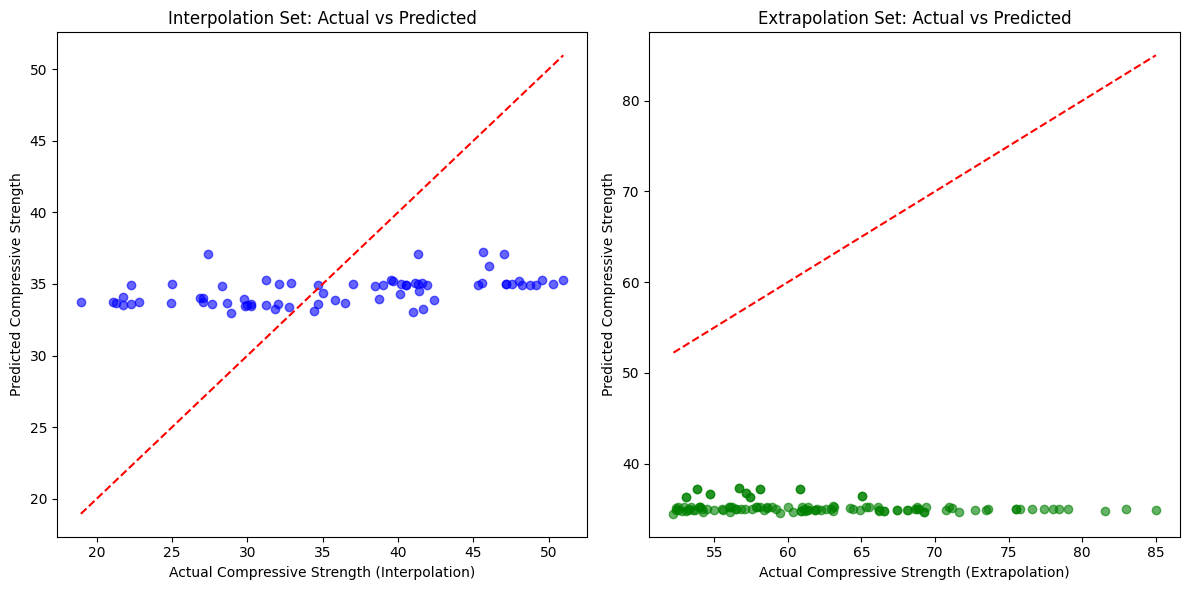

In [4]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Load the previously filtered datasets
interp_train_path = '../excel_files/cubic_to_cylinder_intra_extrapolation/filter_based_on_binder/interpolation_train/only_slag_interpolation_train.xlsx'
interp_test_path = '../excel_files/cubic_to_cylinder_intra_extrapolation/filter_based_on_binder/interpolation_test/only_slag_interpolation_test.xlsx'
extrap_test_path = '../excel_files/cubic_to_cylinder_intra_extrapolation/filter_based_on_binder/extrapolation_test/only_slag_extrapolation_test.xlsx'

df_interp_train = pd.read_excel(interp_train_path)
df_interp_test = pd.read_excel(interp_test_path)
df_extrap_test = pd.read_excel(extrap_test_path)

# Select 10 initial samples randomly from interpolation training set
initial_samples = df_interp_train.sample(n=10, random_state=1)
remaining_interp_train = df_interp_train.drop(initial_samples.index)

# Prepare features and target
features = [
    "SiO2 %",
    "Al2O3 %",
    "Fe2O3 %",
    "CaO %",
    "OPC - content in mix -  (kg/m3)",
    "FA - content in mix -  (kg/m3)",
    "GGBFS - content in mix -  (kg/m3)",
    "SF - content in mix -  (kg/m3)",
    "MK - content in mix -  (kg/m3)",
    "Other SCM - content in mix -  (kg/m3)",
    "Total aggregates - content - (kg/m3)",
    "Water - content from all sources in mix - (kg/m3)",
    "SiO2 - liquid percentage in Na2SiO3 solution - %",
    "SiO2 -Dry content from Na2SiO3 solution in mix - (kg/m3)",
    "NaOH solution - content in mix - (kg/m3)",
    "NaOH solution - concentration - molar",
    "Superplasticizer - content - (kg/m3)",
    "Extra water - content in mix - (kg/m3)",
    "Initial Curing Process - duration - (day)",
    "Initial Curing Process - Temperature - (ºC)",
    "Test age",
]
target = "Compressive test"

# Define features and target for initial sample and test datasets
X_train = initial_samples[features]
y_train = initial_samples[target]
X_interp_test = df_interp_test[features]
y_interp_test = df_interp_test[target]
X_extrap_test = df_extrap_test[features]
y_extrap_test = df_extrap_test[target]

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_interp_test_imputed = imputer.transform(X_interp_test)
X_extrap_test_imputed = imputer.transform(X_extrap_test)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_interp_test_scaled = scaler.transform(X_interp_test_imputed)
X_extrap_test_scaled = scaler.transform(X_extrap_test_imputed)

# Initialize and train the SVR model
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train_scaled, y_train)

# Predict on both interpolation and extrapolation test sets
y_interp_pred = svr_model.predict(X_interp_test_scaled)
y_extrap_pred = svr_model.predict(X_extrap_test_scaled)

# Calculate evaluation metrics
metrics = {
    "R² Score (Interpolation)": r2_score(y_interp_test, y_interp_pred),
    "MAE (Interpolation)": mean_absolute_error(y_interp_test, y_interp_pred),
    "MSE (Interpolation)": mean_squared_error(y_interp_test, y_interp_pred),
    "RMSE (Interpolation)": np.sqrt(mean_squared_error(y_interp_test, y_interp_pred)),
    "R² Score (Extrapolation)": r2_score(y_extrap_test, y_extrap_pred),
    "MAE (Extrapolation)": mean_absolute_error(y_extrap_test, y_extrap_pred),
    "MSE (Extrapolation)": mean_squared_error(y_extrap_test, y_extrap_pred),
    "RMSE (Extrapolation)": np.sqrt(mean_squared_error(y_extrap_test, y_extrap_pred)),
}

# Print the evaluation metrics
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot the predicted vs actual values for both interpolation and extrapolation sets
plt.figure(figsize=(12, 6))

# Interpolation plot
plt.subplot(1, 2, 1)
plt.scatter(y_interp_test, y_interp_pred, color='blue', alpha=0.6)
plt.plot([y_interp_test.min(), y_interp_test.max()], [y_interp_test.min(), y_interp_test.max()], 'r--')
plt.xlabel("Actual Compressive Strength (Interpolation)")
plt.ylabel("Predicted Compressive Strength")
plt.title("Interpolation Set: Actual vs Predicted")

# Extrapolation plot
plt.subplot(1, 2, 2)
plt.scatter(y_extrap_test, y_extrap_pred, color='green', alpha=0.6)
plt.plot([y_extrap_test.min(), y_extrap_test.max()], [y_extrap_test.min(), y_extrap_test.max()], 'r--')
plt.xlabel("Actual Compressive Strength (Extrapolation)")
plt.ylabel("Predicted Compressive Strength")
plt.title("Extrapolation Set: Actual vs Predicted")

plt.tight_layout()
plt.show()
